In [1]:
from scipy.integrate import odeint, solve_ivp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from scipy.optimize import minimize

For this comparmental model, we choose to fit the parameters on the data on confirmed cases provided by the World Health Organization (WHO), collected by this site: https://ourworldindata.org/coronavirus-source-data 

In [77]:
df=pd.read_csv('data/total_cases.csv')
df['date']=pd.to_datetime(df['date'])
df.set_index('date',inplace=True)
country='Italy'
population=60480000.

# Start of the study (con be modified as wanted)
start = pd.Timestamp('2020-02-23')
end = pd.Timestamp('2020-03-15')
days=(end-start).days+1
t = np.linspace(start.value, end.value, days)
t = pd.to_datetime(t)

tempo=np.linspace(1,days,days)


The model we choose is a Susceptible-Exposed-Infected-Recovered (SEIR).  
We specify thaht R0 is not directly a parameter of the model, but you can derive it from other model parameters. Since R0 has the easy-to-say meaning of "secundary cases from a single infected person", it is very popular during this outbreak, and it is very useful to describe the behaviour of the epidemiological curves. In particular, if R0 > 1, the number of infected people increase exponentially without slow-downs. If R0<1, the exponential growth of the outbreak's size does not increase forever and begins to decrease after a single peak. (https://www.icts.res.in/sites/default/files/PuneR0talk.pdf)

In the next chunk, we initialize the parameter we know from literature about COVID-19 (reference will be provided). We also set up some values as a starting point for the fit of the parameters we do not know the value of.

In [78]:
#Known parameters
days_inc=3
days_inf=5+days_inc
mu=1/days_inf
alpha=1/days_inc

#initial guess for parameters to fit from data
R0=2.8
beta=mu*R0
I0=df[df.index==start][country].iloc[0]

The number of confirmed case is known, but it is almost certain that the number of real infected people is much higher than the number of confirmed cases. For this reason, we decide to retrieve the value of infected people at the beginning of the study ($I_0$) from the data, using the number of confirmed cases on the first day only as initial guessing.

As initial value for exposed people ($E_0$), we decide to use the secundary cases generated from the initial $I_0$ infected patients, so $E_0=I_0 * R_0=I_0 * \beta / \mu$. Since $I_0$ and $\beta$ will be fitted on data, also $E_0$ will.

In [79]:
print('Initial parameters: I0={}\nbeta={} alpha={}, mu={}'.format(I0,
                                                            beta,alpha,mu))
N=population
x0=[N-I0-I0*beta/mu,I0*beta/mu,I0,0.]
print(x0)

    
def sumsq(p):
    beta=p[0]
    def SIR_ode(t,x):
        S,E,I,R=x
        dS=-beta*S*I/N
        dE=beta*S*I/N-alpha*E
        dI=alpha*E-mu*I
        dR=mu*I
        return [dS,dE,dI,dR]
    sol=solve_ivp(SIR_ode,[0,days],x0,t_eval=np.arange(0,days+.2,0.2))
    return(sum((sol.y[1][:df.loc[start:,country].shape[0]*5][::5]-
                df.loc[start:,country])**2))

msol = minimize(sumsq,[beta],method='Nelder-Mead',
                options={'maxiter':10000},tol=1e-7)


beta=msol.x[0]
R0=beta/mu
print('\nFitted parameters:\nI0= ',I0)
print('beta:',msol.x[0],' alpha:',alpha, ' mu:',mu)
print('R0:',R0,' days_inc: {} days_ill: {}'.format(1/alpha,1/mu))

Initial parameters: I0=229.0
beta=0.35 alpha=0.3333333333333333, mu=0.125
[60479129.8, 641.1999999999999, 229.0, 0.0]

Fitted parameters:
I0=  229.0
beta: 0.560531122386456  alpha: 0.3333333333333333  mu: 0.125
R0: 4.484248979091648  days_inc: 3.0 days_ill: 8.0


In [80]:
def SIR(x,tempo):
    S,E,I,R=x
    dS=-beta*S*I/N
    dE=beta*S*I/N-alpha*E
    dI=alpha*E-mu*I
    dR=mu*I
    return dS,dE,dI,dR

x0=[N-I0-I0*beta/mu,I0*beta/mu,I0,0.]
integ = odeint(SIR, x0, tempo)
res=pd.DataFrame(integ,columns=['Susceptible','Exposed','Infected','Recovered'])
res['Step']=tempo
res['Day']=t

[None, None]

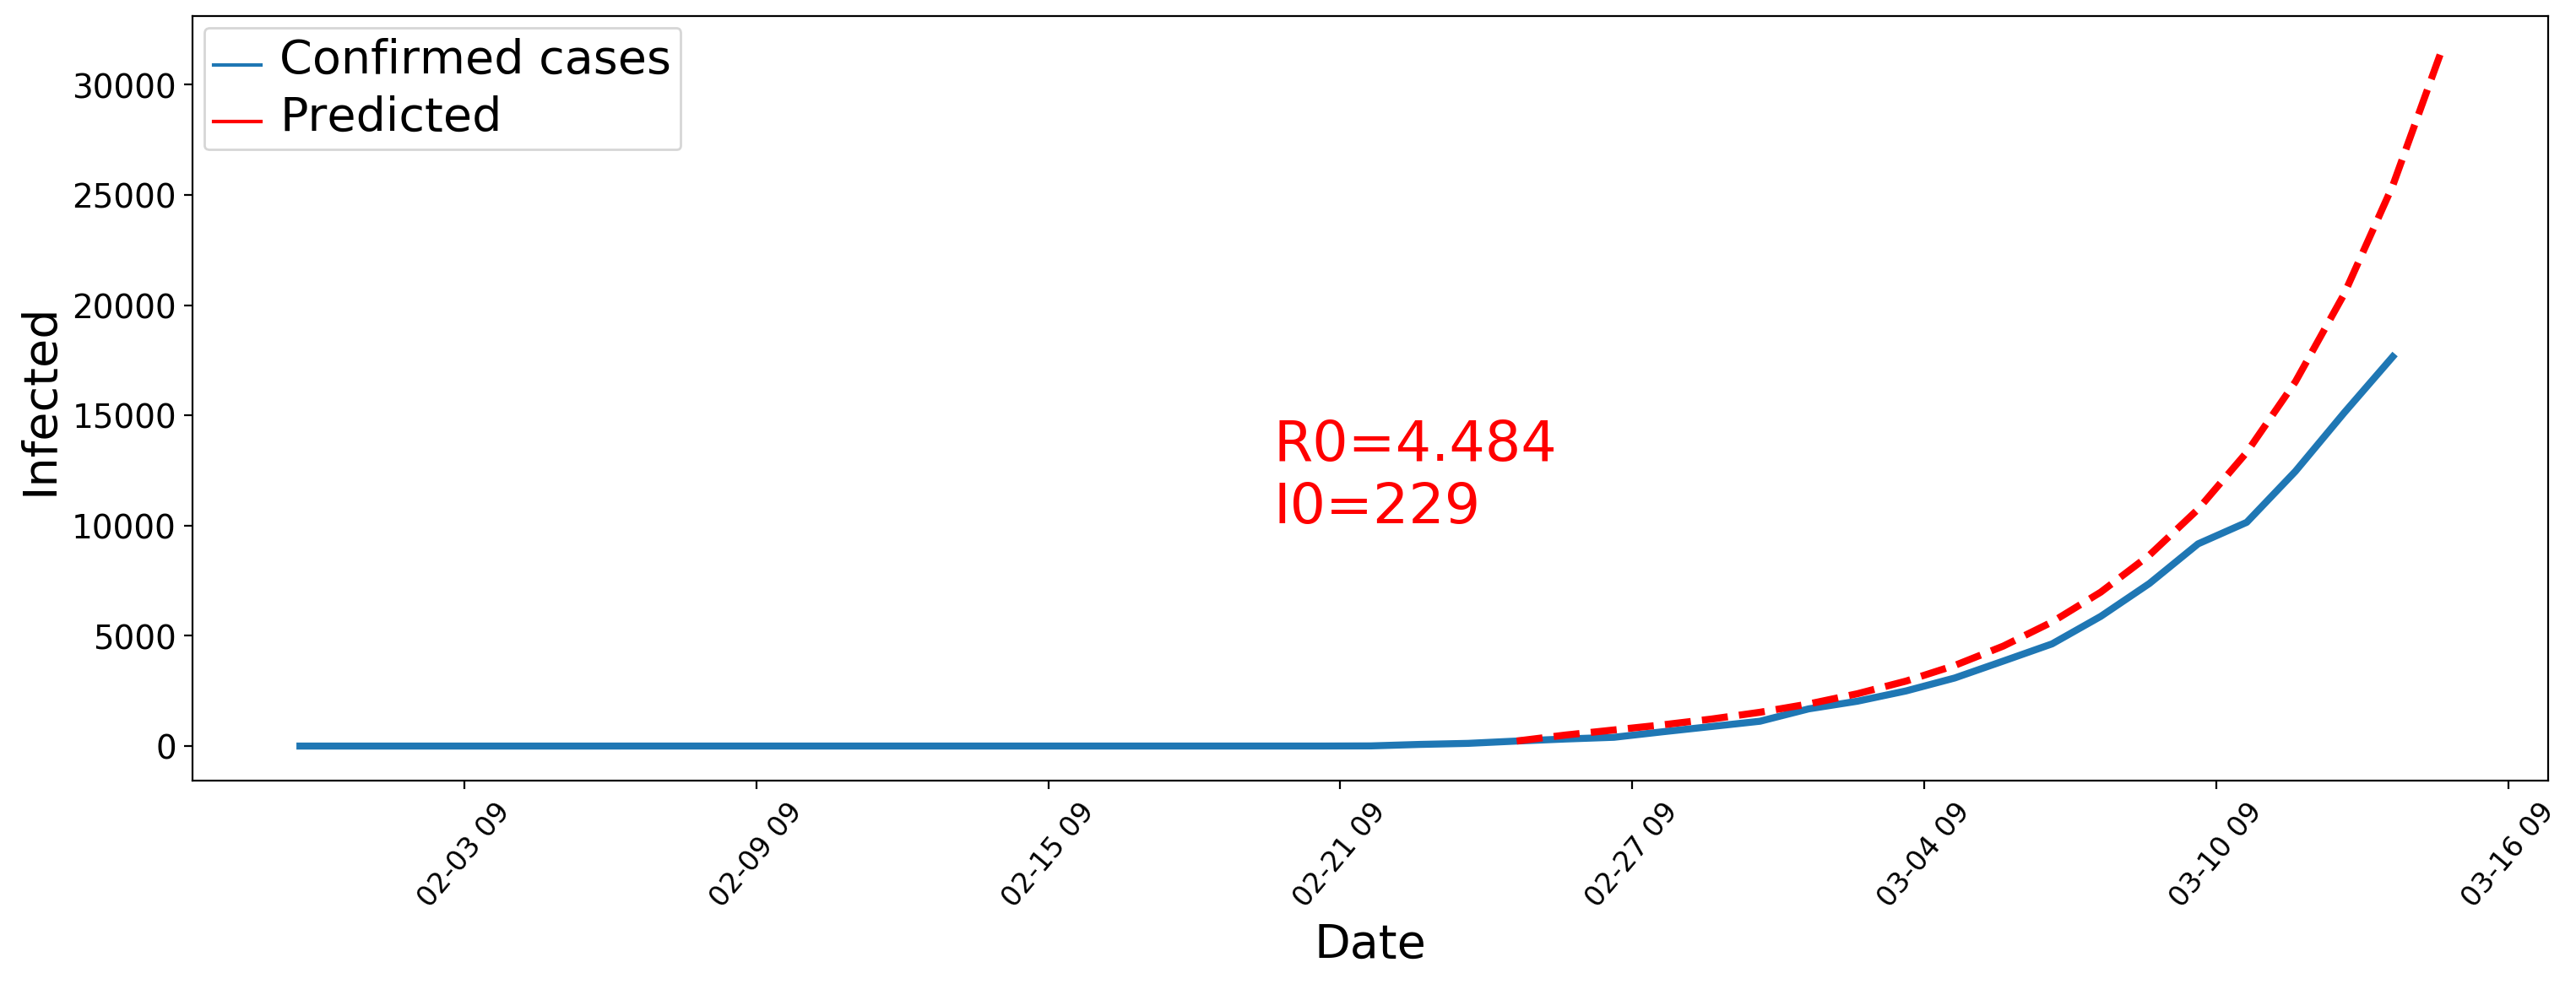

In [81]:
f,ax=plt.subplots(1,1,figsize=(18,6),dpi=200)
sns.lineplot(x=df.index,y=country,data=df,markers='o',ax=ax,
             label='Confirmed cases')
sns.lineplot(x='Day',y='Infected',data=res,ax=ax,label='Predicted',color='r')
plt.setp(ax.lines,linewidth=3)
ax.lines[1].set_linestyle("--")
xticks=plt.xticks(rotation=50,fontsize=12)
yticks=plt.yticks(fontsize=14)
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Infected',fontsize=20)
plt.annotate('R0={:1.3f}\nI0={}'.format(R0,int(I0)),
             xy=(mdates.date2num(df.index[30]), df[country][50]),
             fontsize=24,color='r')
#plt.yscale('log')
ax.xaxis.set_major_locator(mdates.HourLocator(interval=48*3))
plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='18') # for legend title

### Long time behaviour

[None, None]

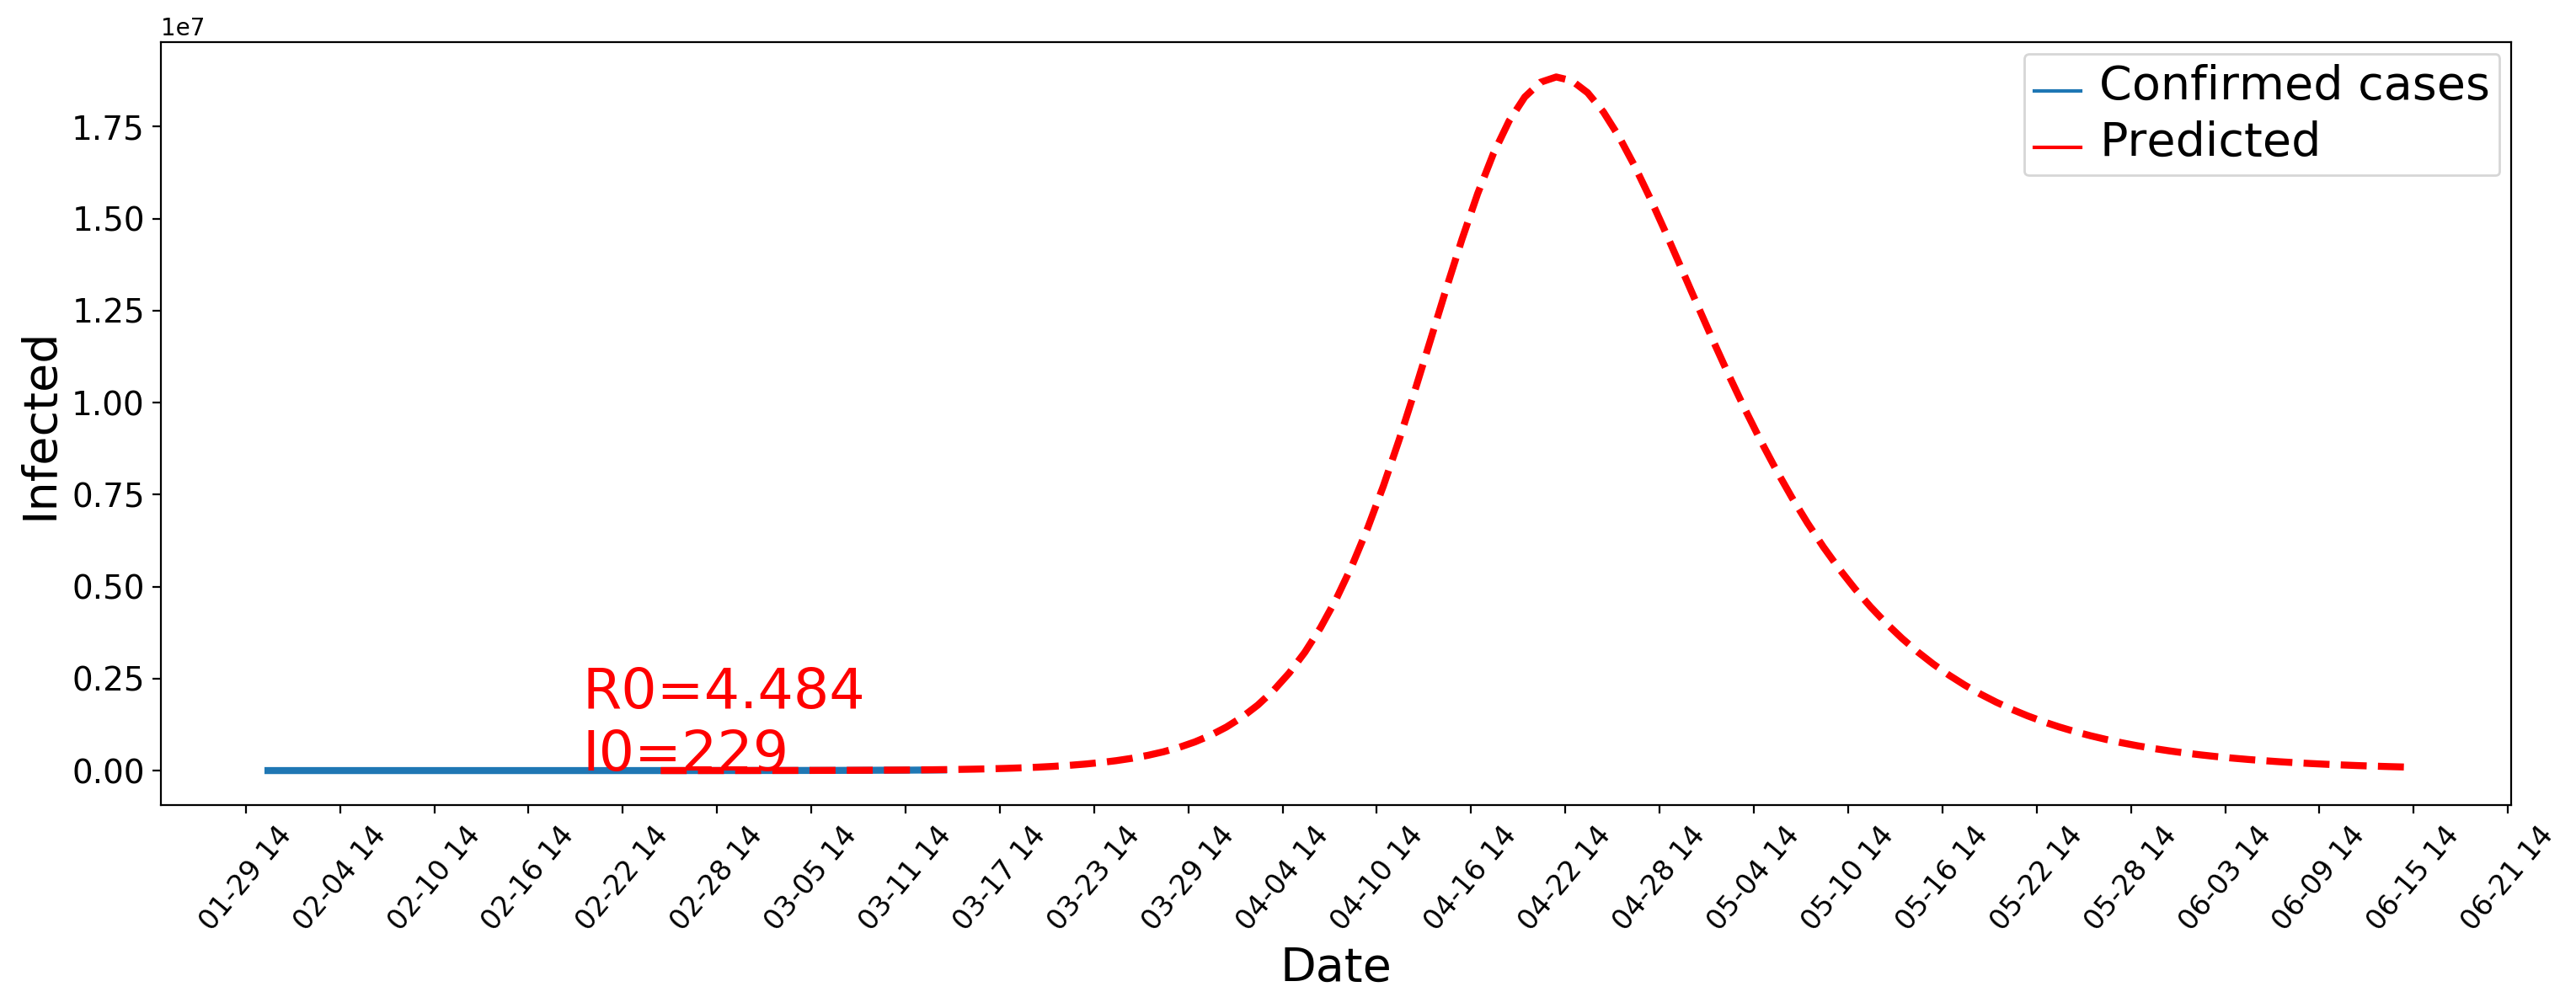

In [84]:
end = pd.Timestamp('2020-06-15')
days=(end-start).days+1
t_long = np.linspace(start.value, end.value, days)
t_long = pd.to_datetime(t_long)
tempo_long=np.linspace(1,days,days)


integ = odeint(SIR, x0, tempo_long)
res_long=pd.DataFrame(integ,columns=['Susceptible','Exposed','Infected','Recovered'])
res_long['Step']=tempo_long
res_long['Day']=t_long

f,ax=plt.subplots(1,1,figsize=(18,6),dpi=200)
sns.lineplot(x=df.index,y=country,data=df,markers='o',ax=ax,
             label='Confirmed cases')
sns.lineplot(x='Day',y='Infected',data=res_long,ax=ax,label='Predicted',color='r')
plt.setp(ax.lines,linewidth=3)
ax.lines[1].set_linestyle("--")
xticks=plt.xticks(rotation=50,fontsize=12)
yticks=plt.yticks(fontsize=14)
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Infected',fontsize=20)
plt.annotate('R0={:1.3f}\nI0={}'.format(R0,int(I0)),
             xy=(mdates.date2num(df.index[30]), df[country][50]),
             fontsize=24,color='r')
#plt.yscale('log')
ax.xaxis.set_major_locator(mdates.HourLocator(interval=48*3))
plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='18') # for legend title

In [19]:
beta/(mu+alpha)

1.4819562515552256